# CEO 

In [1]:
import sys
sys.path.append('../')


import uuid

######### React agent ############
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import HumanMessage
from langchain_core.prompts import PromptTemplate

###### From config #######
from config import Config
conf = Config()

####### From Resources #####
from utils.resource_manager import ResourceManager
resource_manager = ResourceManager.get_instance()

import pandas as pd


##### Agent ##############
from langgraph_supervisor import create_supervisor
from langgraph_supervisor.handoff import create_forward_message_tool
from agents.news_agent import news_agent
from agents.search_agent import search_agent
from agents.central_memory_supervisor import cms




/opt/miniconda3/envs/AgenticAI-env/lib/python3.13/site-packages/pyowm/commons/cityidregistry.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


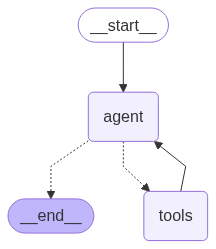

In [2]:
news_agent

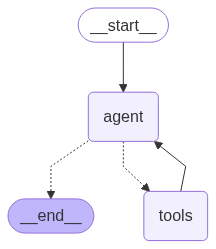

In [3]:
search_agent

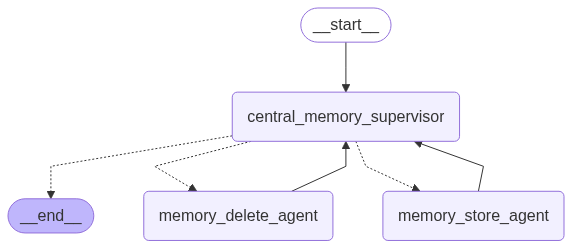

In [4]:
cms

# Supervisor 

## Prompt (Build Using Langchain)

In [5]:
try:
    long_term_memory = pd.read_csv(f"{conf.memory_path}/Permanent_Memory.csv")

except:
    long_term_memory = pd.DataFrame()

try:    
    reminders = pd.read_csv(f"{conf.memory_path}/Reminders.csv")

except:
    reminders = pd.DataFrame()

In [6]:
long_term_memory_str = long_term_memory.to_json(orient='records', indent=4)
reminders_str = reminders.to_json(orient='records', indent=4)

In [7]:

prompt_blueprint = resource_manager.prompt_loader("ceo_prompt")

prompt_template = PromptTemplate.from_template(prompt_blueprint)
prompt = prompt_template.invoke({"ToolMessage": '{"tool":"forwarded_response","args":{"from_agent":"news_agent"}}',
                            "long_term_memory_string": long_term_memory_str,
                            "reminder_string": reminders_str}).to_string()

print(prompt)

You are Ryo, intelligent health and lifestyle supervisor overseeing three specialized agents:
- News Agent: Fetches up-to-date news articles.
- Search agent: Retrieves general web articles, reference pages, or informational content, also has the capability of getting weather.
- Central Memory Supervisor (CMS): Maintains and retrieves relevant long-term memories to inform and personalize conversations.

<Agent Instructions>
1. Classify the user query:
   - If it’s about current events or headlines, invoke News Agent. If you have user preferences saved, use it while generating an output to user queries depending on if its a general or a specific query.
   Example: General queries - Give the latest headlines - tailor  user preferences. Specific queries - What is the latest news regarding US politics. No need to tailor to user preferences.
   - If it’s seeking background information or explanatory articles or weather, invoke Search Agent.
   - If its asking to remember a memory, set a remi

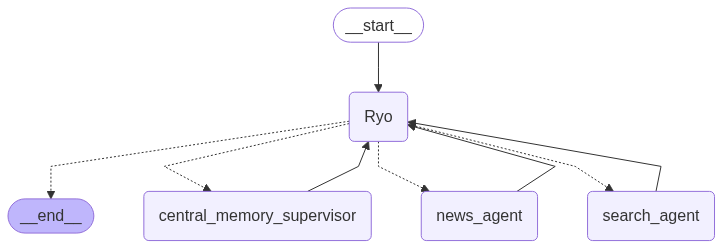

In [8]:
forwarding_tool = create_forward_message_tool("forwarded_response")

graph = create_supervisor([news_agent, cms, search_agent], 
                        model=conf.model, 
                        supervisor_name='Ryo',
                        prompt=prompt,
                        tools=[forwarding_tool],
                        output_mode='last_message')
ryo = graph.compile(checkpointer=InMemorySaver())
ryo



In [10]:
resource_manager.stream_agent(ryo.stream(
    {"messages": [{"role": "user", "content":  "Remember my name is Siddharth"}]},
    conf.ryo_configs, stream_mode="values")
)

================================ Human Message =================================

Remember my name is Siddharth
================================== Ai Message ==================================
Name: Ryo

I already have that saved! Your full name is Siddharth Mandgi, but I will call you Sid.


[HumanMessage(content='Remember my name is Siddharth', additional_kwargs={}, response_metadata={}, id='178c504b-3cc8-4172-930d-4d1e0a84734c'),
 AIMessage(content='I already have that saved! Your full name is Siddharth Mandgi, but I will call you Sid.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 1783, 'total_tokens': 1807, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1664}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BnohEewzLhvBbJwOVzrPfjuBV2j8l', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='Ryo', id='run--96b55595-225e-4a86-ab76-19ed99fb52e9-0', usage_metadata={'input_tokens': 1783, 'output_tokens': 24, 'total_tokens': 1807, 'input_token_details': {'audio': 0, 'cache_read': 1664}, 'ou

In [10]:
resource_manager.stream_agent(cms.stream(
    {"messages": [{"role": "user", "content":  "Update my name to SID"}]},
    conf.ryo_configs, stream_mode="values"))

================================ Human Message =================================

Update my name to SID
================================= Tool Message =================================
Name: transfer_to_memory_delete_agent

Successfully transferred to memory_delete_agent
content='' additional_kwargs={'tool_calls': [{'id': 'call_HkSI35kia4iNjSXfCbwdkeAU', 'function': {'arguments': '{"context": "My name is Siddharth"}', 'name': 'extract_specific_memory_from_all_memories'}, 'type': 'function'}, {'id': 'call_xZ9cvUxgbucp58lmWGh75Qok', 'function': {'arguments': '{"index_title": "Permanent: User\'s Name"}', 'name': 'extract_index_title_of_the_specific_memory'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 354, 'total_tokens': 418, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_to

/Users/siddharth/Desktop/Data-Science-Universe/Projects/LLMS/Ryo/notebooks/../agents/memory_store_agent.py:252: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  central_memory = pd.concat([central_memory, pd.DataFrame(response.model_dump(), index=[0])], ignore_index=True)


================================= Tool Message =================================
Name: transfer_back_to_central_memory_supervisor

Successfully transferred back to central_memory_supervisor
================================== Ai Message ==================================
Name: central_memory_supervisor

Your request to update the name to SID has been successfully processed and stored as a permanent memory.


[HumanMessage(content='Update my name to SID', additional_kwargs={}, response_metadata={}, id='55909132-8d80-4b26-96fe-c9f6fa2f228d'),
 ToolMessage(content='Successfully transferred to memory_delete_agent', name='transfer_to_memory_delete_agent', id='b15b556c-5522-44ca-abfc-c82ca8e890d9', tool_call_id='call_KKGhkrcCptcteexpqyoVNyTG'),
 ToolMessage(content='Successfully transferred back to central_memory_supervisor', name='transfer_back_to_central_memory_supervisor', id='4df65c38-b35b-4f53-8f5c-56a602bef1c0', tool_call_id='f13e430b-56c9-4cc1-a96b-292ea0e82946'),
 ToolMessage(content='Successfully transferred to memory_store_agent', name='transfer_to_memory_store_agent', id='230ac739-3f87-4a2a-8543-0f3ce7d26808', tool_call_id='call_cOfi1XRQAtR9ijbQf3zF4hUY'),
 ToolMessage(content='Successfully transferred back to central_memory_supervisor', name='transfer_back_to_central_memory_supervisor', id='65d88414-2e97-46dc-8681-cf8b840cc881', tool_call_id='f44ac59f-e419-4089-8db5-d824424f1a42'),
 

In [15]:
resource_manager.stream_agent(ryo.stream(
    {"messages": [{"role": "user", "content":  "Remind me to learn driving by Tomorrow"}]},
    conf.ryo_configs, stream_mode="values"))

================================ Human Message =================================

Remind me to learn driving by Tomorrow
================================== Ai Message ==================================
Name: Ryo

I will remind you to learn driving by tomorrow.


[HumanMessage(content='Remind me to learn driving by Tomorrow', additional_kwargs={}, response_metadata={}, id='d948883d-7a61-40ac-891a-307a7acb43c3'),
 AIMessage(content='I will remind you to learn driving by tomorrow.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 3178, 'total_tokens': 3189, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 3072}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BngRaXYNSXKA9bJVF2vB7KNoft95D', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='Ryo', id='run--d0411b9d-d32b-476e-ae72-3a4210a964db-0', usage_metadata={'input_tokens': 3178, 'output_tokens': 11, 'total_tokens': 3189, 'input_token_details': {'audio': 0, 'cache_read': 3072}, 'output_token_details': {'audio': 

In [19]:
ryo.invoke(
    {"messages": [{"role": "user", "content": "What are my reminders?"}]},
    conf.ryo_configs
)

{'messages': [HumanMessage(content='Remember my name is Siddharth', additional_kwargs={}, response_metadata={}, id='0bea3300-0dd7-4f4a-9fe8-d3a9ab28ab52'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dtzRfH7gc3VdZVkTyJt2NtWf', 'function': {'arguments': '{}', 'name': 'transfer_to_central_memory_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 298, 'total_tokens': 312, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BnJWa6qVJzazml5CCEBjB92zifqNk', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Ryo', id='run--0e62f21c-84f4-415d-b2a1-f34467a87e4e-0', tool_calls=[{'name': 'transfer_to_central_memory_agent', 'a

In [ ]:
ryo.invoke(
    {"messages": [{"role": "user", "content": "What did I ask just now?"}]},
    conf.ryo_configs
)

{'messages': [HumanMessage(content='What is the latest news? Give me some headlines for this week in United States on - Politics, Sports, Technology, AI. Also provide some context on each of these headlines', additional_kwargs={}, response_metadata={}, id='c9c683c5-5261-4271-acb8-90ba45b0e410'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KTZsqLXo3DnhVckQlrtAutUG', 'function': {'arguments': '{}', 'name': 'transfer_to_news_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 189, 'total_tokens': 201, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BnH3UpfjOEhYulhB8guE4q8i0jJb5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs

In [18]:
resource_manager.stream_agent(ryo.stream(
    {"messages": [{"role": "user", "content":  "What is the latest news? Give me some headlines for this week in United States on - Politics, Sports, Technology, AI. Also provide some context on each of these headlines"}]},
    conf.ryo_configs, stream_mode="values")
)

================================ Human Message =================================

What is the latest news? Give me some headlines for this week in United States on - Politics, Sports, Technology, AI. Also provide some context on each of these headlines
================================= Tool Message =================================
Name: transfer_to_news_agent

Successfully transferred to news_agent
================================= Tool Message =================================
Name: transfer_back_to_ryo

Successfully transferred back to Ryo
================================== Ai Message ==================================
Name: Ryo

{"tool":"forwarded_response","args":{"from_agent":"news_agent"}}


[HumanMessage(content='What is the latest news? Give me some headlines for this week in United States on - Politics, Sports, Technology, AI. Also provide some context on each of these headlines', additional_kwargs={}, response_metadata={}, id='b11d761c-52dc-4610-9a47-828eb382733c'),
 ToolMessage(content='Successfully transferred to news_agent', name='transfer_to_news_agent', id='eb6d6f29-bd36-433a-ba93-5329445a7e63', tool_call_id='call_rhmxfKioNLeLINqkvquLHqRg'),
 ToolMessage(content='Successfully transferred back to Ryo', name='transfer_back_to_ryo', id='f4107156-ee1a-4c54-a65e-8d4c9685daf1', tool_call_id='64ccd3b4-d8b2-4c13-ae77-de1240403603'),
 AIMessage(content='{"tool":"forwarded_response","args":{"from_agent":"news_agent"}}', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 3508, 'total_tokens': 3524, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_p

In [13]:
resource_manager.stream_agent(ryo.stream(
    {"messages": [{"role": "user", "content": "What is the latest news?"}]},
    conf.ryo_configs, stream_mode="values"))

================================ Human Message =================================

What is the latest news?
================================= Tool Message =================================
Name: transfer_to_news_agent

Successfully transferred to news_agent
================================= Tool Message =================================
Name: transfer_back_to_ryo

Successfully transferred back to Ryo
================================== Ai Message ==================================
Name: Ryo

Here are some of the latest news highlights:

1. **Dangerous Heat Waves & Box Office Bounce Back** - Top stories cover Iranian missiles intercepted near a US base, a tragic boating accident on Lake Tahoe, and legislative actions on THC products in Texas.

2. **TikTok Star Jenna Davis** - Gaining attention with her new country album and a role in 'M3GAN 2.0'.

3. **Brad Pitt’s Home Ransacked** - Incident reported involving Brad Pitt's Los Angeles residence.

4. **Wildfire Updates** - Includes ongoing 

[HumanMessage(content='What is the latest news?', additional_kwargs={}, response_metadata={}, id='5d4b985a-0c1e-46d8-8ef3-8ec01087b5bd'),
 ToolMessage(content='Successfully transferred to news_agent', name='transfer_to_news_agent', id='30e5f0b4-acb7-467b-82de-abd7c9c81550', tool_call_id='call_zYrdGYzygSq5JQcmnDkDQZkl'),
 ToolMessage(content='Successfully transferred back to Ryo', name='transfer_back_to_ryo', id='d9d82f98-537e-46e0-b7e1-b1ee8dfe4a42', tool_call_id='6d58bdd3-cad6-4753-9632-32381e3e77ee'),
 AIMessage(content="Here are some of the latest news highlights:\n\n1. **Dangerous Heat Waves & Box Office Bounce Back** - Top stories cover Iranian missiles intercepted near a US base, a tragic boating accident on Lake Tahoe, and legislative actions on THC products in Texas.\n\n2. **TikTok Star Jenna Davis** - Gaining attention with her new country album and a role in 'M3GAN 2.0'.\n\n3. **Brad Pitt’s Home Ransacked** - Incident reported involving Brad Pitt's Los Angeles residence.\n\n4

In [17]:
resource_manager.stream_agent(ryo.stream(
    {"messages": [{"role": "user", "content": "Can you find articles on me?"}]},
    conf.ryo_configs, stream_mode="values")
)

================================ Human Message =================================

Can you find articles on me?
================================= Tool Message =================================
Name: transfer_to_search_agent

Successfully transferred to search_agent
================================= Tool Message =================================
Name: transfer_back_to_ryo

Successfully transferred back to Ryo
================================== Ai Message ==================================
Name: Ryo

I couldn't find specific articles about you. If you have additional details or specific areas you'd like to search for, let me know and I can try a more refined search!


[HumanMessage(content='Can you find articles on me?', additional_kwargs={}, response_metadata={}, id='ae91d7e3-bcd8-467c-8f1b-f3f33cf48405'),
 ToolMessage(content='Successfully transferred to search_agent', name='transfer_to_search_agent', id='1fe18564-1217-48be-a0c1-b9f4ee5fe8e9', tool_call_id='call_dqWJeOD6vJitVMjajvqPRrTt'),
 ToolMessage(content='Successfully transferred back to Ryo', name='transfer_back_to_ryo', id='e3d812c0-00c8-41aa-b608-eec048e4b6dc', tool_call_id='af66d4a9-7d49-4c9c-87b9-00f3d7bc3468'),
 AIMessage(content="I couldn't find specific articles about you. If you have additional details or specific areas you'd like to search for, let me know and I can try a more refined search!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 2252, 'total_tokens': 2287, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tok

In [14]:
resource_manager.stream_agent(ryo.stream(
    {"messages": [{"role": "user", "content": "Who am I?"}]},
    conf.ryo_configs, stream_mode="values"))

================================ Human Message =================================

Who am I?
================================= Tool Message =================================
Name: transfer_to_central_memory_supervisor

Successfully transferred to central_memory_supervisor
================================= Tool Message =================================
Name: transfer_back_to_ryo

Successfully transferred back to Ryo
================================== Ai Message ==================================
Name: Ryo

I remember that your full name is Siddharth Mandgi. If there's anything else you'd like me to recall, please let me know!


[HumanMessage(content='Who am I?', additional_kwargs={}, response_metadata={}, id='31d69a25-e9eb-4f52-9db3-1f93bdd4d269'),
 ToolMessage(content='Successfully transferred to central_memory_supervisor', name='transfer_to_central_memory_supervisor', id='bdc0c2d9-4285-4042-8556-1f5781ce6da8', tool_call_id='call_b4DMrjCuaLp42kdAGje9Jaea'),
 ToolMessage(content='Successfully transferred back to Ryo', name='transfer_back_to_ryo', id='f46bff27-291d-40aa-a1b6-ace224f12bf9', tool_call_id='7155b793-e737-4a69-b9c6-76cdbd57a243'),
 AIMessage(content="I remember that your full name is Siddharth Mandgi. If there's anything else you'd like me to recall, please let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 3132, 'total_tokens': 3161, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cache

In [9]:
resource_manager.stream_agent(ryo.stream(
    {"messages": [{"role": "user", "content": "What is the weather in New Jersey?"}]},
    conf.ryo_configs, stream_mode="values"))

================================ Human Message =================================

What is the weather in New Jersey?
================================= Tool Message =================================
Name: transfer_to_search_agent

Successfully transferred to search_agent
================================= Tool Message =================================
Name: transfer_back_to_ryo

Successfully transferred back to Ryo
================================== Ai Message ==================================
Name: Ryo

Currently, clear skies prevail in New Jersey with a temperature of 30.96°C. The day is expected to see a high of 32.21°C and a low of 29.88°C. There's a gentle northwest breeze at 3.6 m/s, with humidity at 63%, making it feel like 35.53°C overall. Enjoy the bright and sunny day!


[HumanMessage(content='What is the weather in New Jersey?', additional_kwargs={}, response_metadata={}, id='5ca12a5b-cc0c-47de-a574-501337633a30'),
 ToolMessage(content='Successfully transferred to search_agent', name='transfer_to_search_agent', id='69936dc3-58d2-4558-ad28-c87d89042a52', tool_call_id='call_YkcVrNyQErOlnyHBx5xJKErR'),
 ToolMessage(content='Successfully transferred back to Ryo', name='transfer_back_to_ryo', id='63c309a9-c63e-4cb7-8e10-8abef0cd5928', tool_call_id='d76d383a-6612-4f90-8c8e-ba53a9c6b232'),
 AIMessage(content="Currently, clear skies prevail in New Jersey with a temperature of 30.96°C. The day is expected to see a high of 32.21°C and a low of 29.88°C. There's a gentle northwest breeze at 3.6 m/s, with humidity at 63%, making it feel like 35.53°C overall. Enjoy the bright and sunny day!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 1969, 'total_tokens': 2049, 'completion_tokens_details': {'ac